# Open Food Facts Dataset

# I have included comments below. Here, I am mentioning few important points that you need to consider in general !
Donot include tables, because there are graphs for the same stuff. You need to explain each plot/ result, and include conclusion too. Do proper labeling, for both horizontal and vertical axis of each plot/grpah. There are some countries, food categories, and labels with single entries! can you verify, the single entries for some countries include those category/food labels, with single entries? How many different products and brands are there?      

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
import seaborn as sns
import numpy as np

import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import paired_cosine_distances

warnings.filterwarnings("ignore")
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

**Function to split strings from https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows**

In [3]:
def tidy_split(df, column, sep='|', keep=False):
    """
    Split the values of a column and expand so the new DataFrame has one split
    value per row. Filters rows where the column is missing.

    Params
    ------
    df : pandas.DataFrame
        dataframe with the column to split and expand
    column : str
        the column to split and expand
    sep : str
        the string used to split the column's values
    keep : bool
        whether to retain the presplit value as it's own row

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns as `df`.
    """
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df

In [6]:
data_all = pd.read_csv("en.openfoodfacts.org.products.tsv", sep='\t')
print("DataFrame shape: {}".format(data_all.shape))
pd.set_option('display.max_columns', data_all.shape[1], 'display.max_rows', data_all.shape[1])
data_all.head()

DataFrame shape: (356027, 163)


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,main_category,main_category_en,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","To be completed,Nutrition facts to be complete...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,United States,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN

In [12]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356027 entries, 0 to 356026
Columns: 163 entries, code to water-hardness_100g
dtypes: float64(107), object(56)
memory usage: 442.8+ MB


# Remove null columns
Remove the columns which contains all N/A values

In [14]:
data_validcols = data_all.dropna(axis=1, how='all')

nullcols = data_all.isnull().all(axis=0)
nullcols = nullcols[nullcols == True].keys()
pd.DataFrame(nullcols, columns=['Null columns'])

,Null columns
0,no_nutriments
1,ingredients_from_palm_oil
2,ingredients_that_may_be_from_palm_oil
3,nutrition_grade_uk
4,-butyric-acid_100g
5,-caproic-acid_100g
6,-lignoceric-acid_100g
7,-cerotic-acid_100g
8,-melissic-acid_100g
9,-elaidic-acid_100g


# Important columns

In [15]:
nutr_cols_important = [
'energy_100g',
'fat_100g',
'carbohydrates_100g',
'sugars_100g',
'fiber_100g',
'proteins_100g',
'salt_100g',
]
nutr_cols = nutr_cols_important + [
'saturated-fat_100g',
'sodium_100g',
'nutrition-score-fr_100g',
'nutrition-score-uk_100g'
]
nutrs_cols_weak = [
'vitamin-a_100g',
'vitamin-c_100g',
'calcium_100g',
'iron_100g'
]

data_cats = data_validcols.dropna(subset=['categories_tags'])

# Proportion of valid values to N/A in each column
List of valid columns and the percentage of valid values in each column 

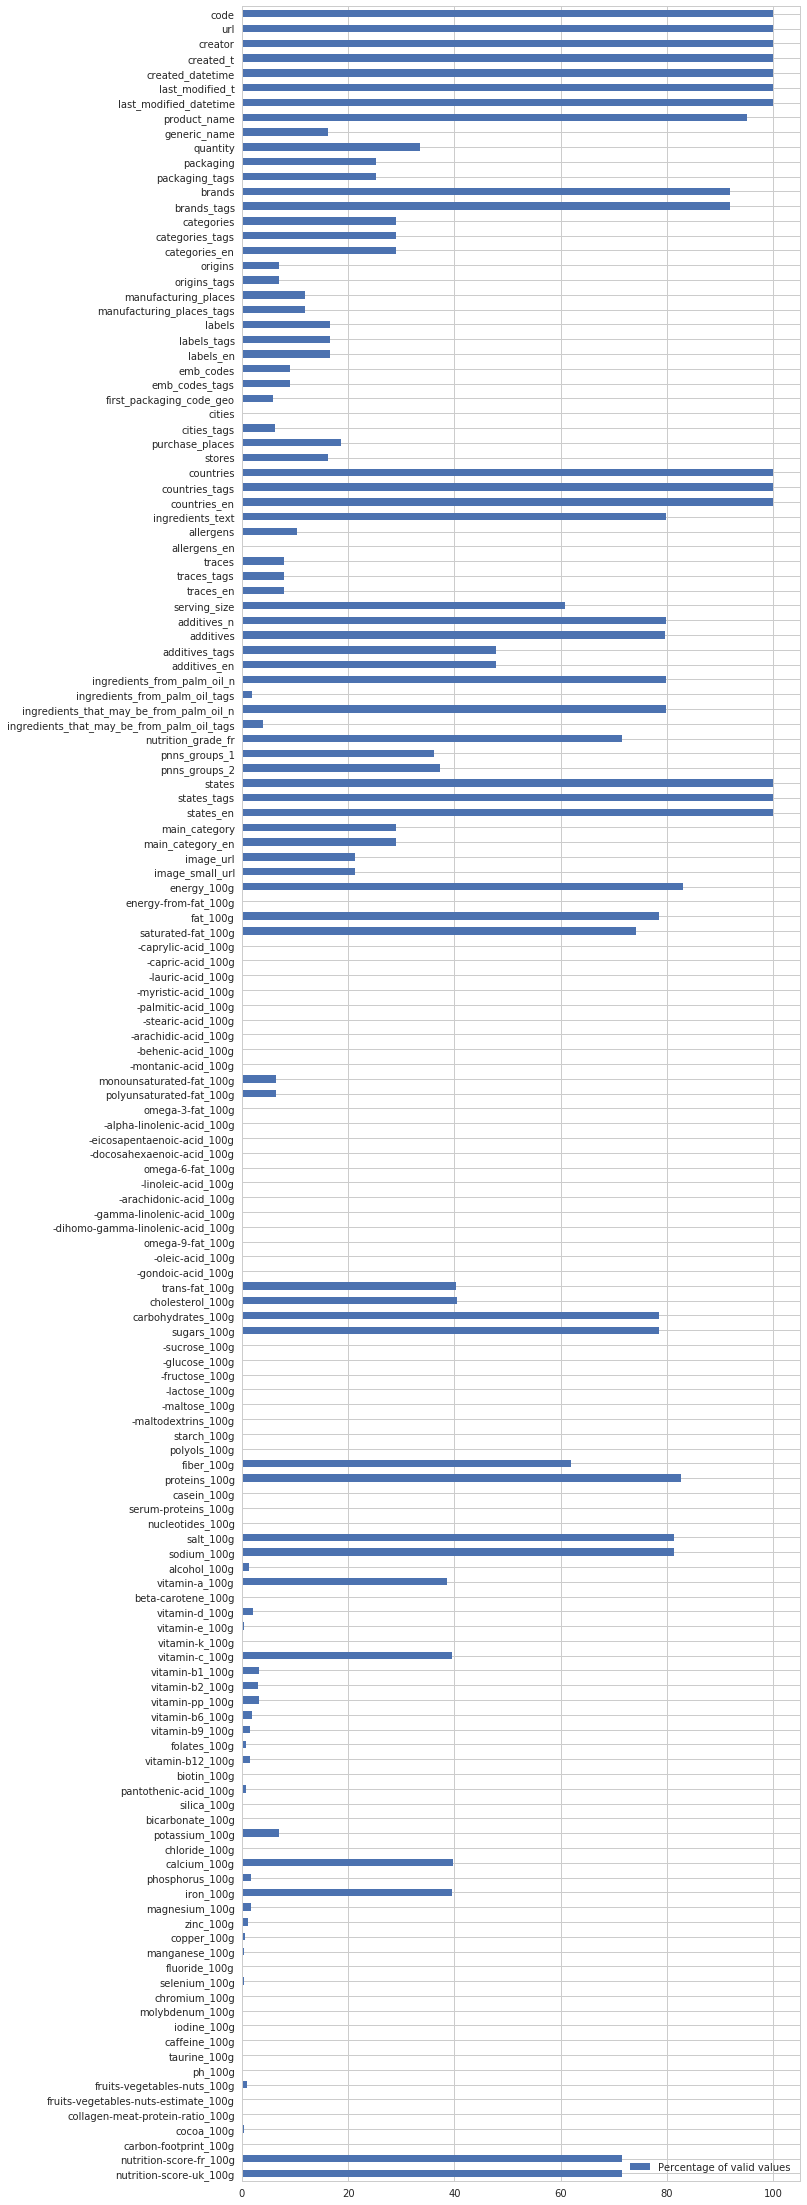

In [17]:
validratio = ~data_validcols.isnull()
validratio = validratio.sum(axis=0).iloc[::-1]
validratio = pd.DataFrame(validratio/data_validcols.shape[0] * 100, columns=['Percentage of valid values'])
validratio.plot(kind='barh', figsize=(10,40))

# Countries represented in the dataset

In [20]:
countries = data_validcols[['countries_en']].dropna()
countries = tidy_split(countries, column='countries_en', sep=',')
countries = countries.groupby(['countries_en']).size().sort_values(ascending=False)
countries = pd.DataFrame(countries, columns=['Entries'])
countries

,Entries
countries_en,
United States,173708
France,129320
Switzerland,17204
Germany,9403
Spain,6061
United Kingdom,5987
Belgium,4088
Australia,2319
Russia,1641


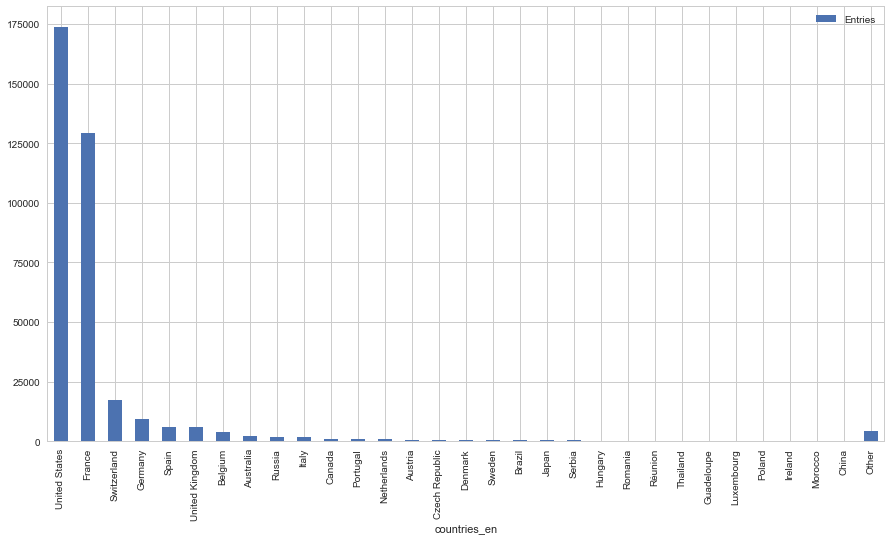

In [9]:
countries_bar = countries[0:30]
countries_bar = countries_bar.append(pd.Series(countries[30:].sum(), name='Other'))
countries_bar.plot(kind="bar", figsize=(15, 8))

# combine the zoomed in version with above graph. 
check this link: https://stackoverflow.com/questions/13583153/how-to-zoomed-a-portion-of-image-and-insert-in-the-same-plot-in-matplotlib

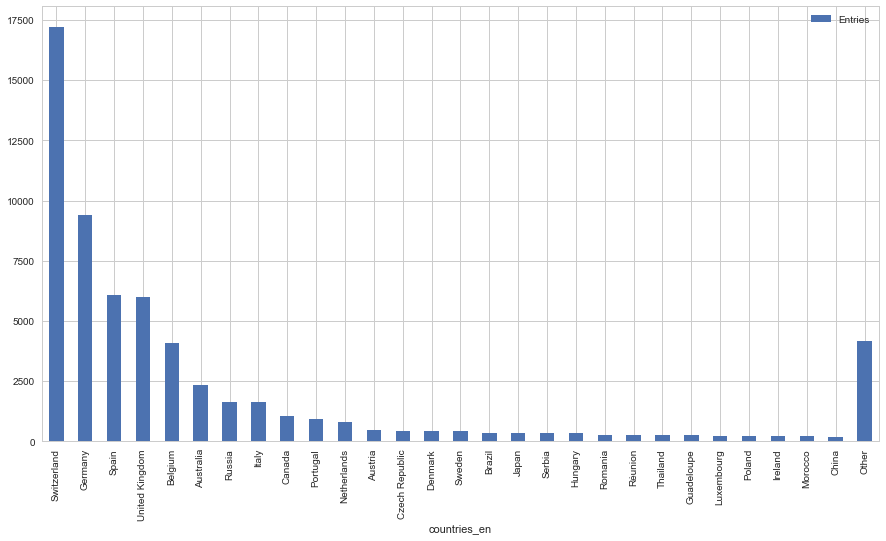

In [10]:
countries_bar.drop({'United States', 'France'}).plot(kind="bar", figsize=(15, 8))

# Palm oil by country comparison
same comments, combine following two figures into one !

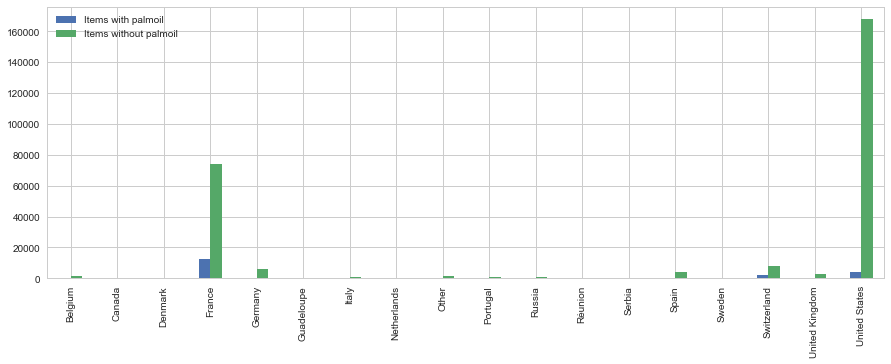

In [11]:
palmoilcols = ['ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n']
countrycols = ['countries_en']

data_palmoil = data_validcols[palmoilcols + countrycols].dropna()
data_palmoil['palm_c'] = data_palmoil[palmoilcols].max(axis=1)

other_thres = 20
data_palmoil_t = data_palmoil[data_palmoil['palm_c'] != 0]
data_palmoil_t = tidy_split(data_palmoil_t, column='countries_en', sep=',')
tcc = data_palmoil_tcc = pd.DataFrame(data_palmoil_t.groupby(['countries_en']).size().sort_values(ascending=False))
tcc_other = pd.Series(data_palmoil_tcc[other_thres:].sum(), name='Other')
data_palmoil_tcc = data_palmoil_tcc.drop(data_palmoil_tcc.index[other_thres:])
data_palmoil_tcc = data_palmoil_tcc.append(tcc_other)

data_palmoil_f = data_palmoil[data_palmoil['palm_c'] == 0]
data_palmoil_f = tidy_split(data_palmoil_f, column='countries_en', sep=',')
fcc = data_palmoil_fcc = pd.DataFrame(data_palmoil_f.groupby(['countries_en']).size().sort_values(ascending=False))
fcc_other = pd.Series(data_palmoil_fcc[other_thres:].sum(), name='Other')
data_palmoil_fcc = data_palmoil_fcc.drop(data_palmoil_fcc.index[other_thres:])
data_palmoil_fcc = data_palmoil_fcc.append(fcc_other)

data_palmoil_bar = pd.concat([data_palmoil_tcc, data_palmoil_fcc], axis=1).dropna()
data_palmoil_bar.columns = ["Items with palmoil", "Items without palmoil"]
data_palmoil_bar.plot(kind='bar', figsize=(15,5))

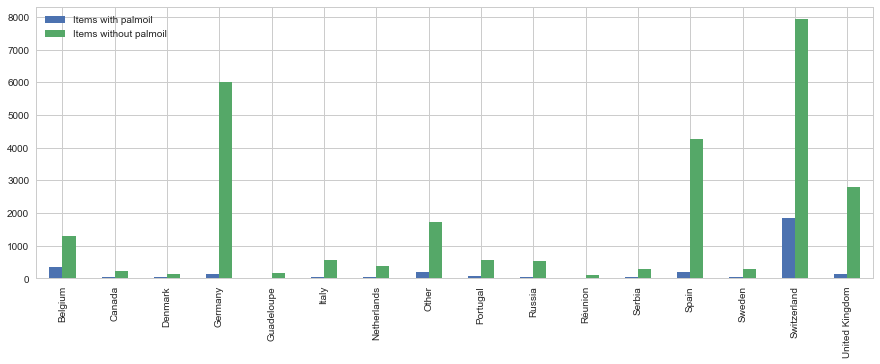

In [12]:
data_palmoil_bar.drop(["United States", "France"]).plot(kind='bar', figsize=(15,5))

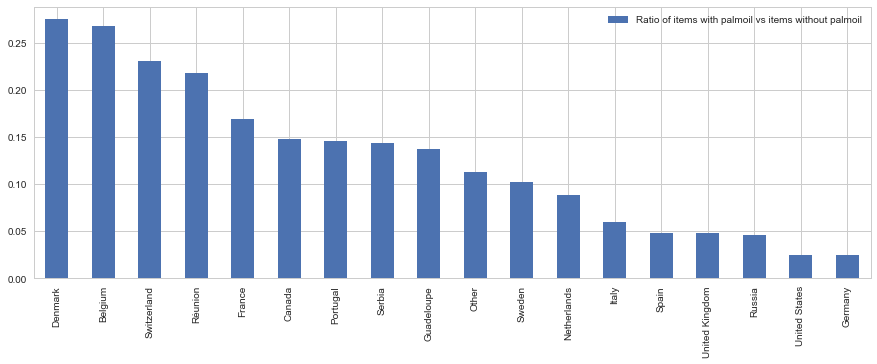

In [13]:
data_palmoil_ratio = data_palmoil_bar.apply(lambda x: x['Items with palmoil']/x['Items without palmoil'], axis=1)
data_palmoil_ratio = pd.DataFrame(data_palmoil_ratio).sort_values(ascending=False, by=0)
data_palmoil_ratio.columns = ['Ratio of items with palmoil vs items without palmoil']
data_palmoil_ratio.plot(kind='bar', figsize=(15, 5))

In [14]:
#ratio_bar = pd.concat([tcc, fcc], axis=1).dropna()
#ratio_bar.columns = ['w', 'wo']
#ratio_bar = ratio_bar[(ratio_bar['w'] > 10) & (ratio_bar['wo'] > 10)]
#ratio_bar = ratio_bar.apply(lambda x: x['w']/x['wo'], axis=1)
#ratio_bar = pd.DataFrame(ratio_bar).sort_values(ascending=False, by=0)
#ratio_bar.columns = ['Ratio of items with palmoil vs items without palmoil']
#ratio_bar.plot(kind='bar', figsize=(15, 5))

# Dataset entries histroy
Combine following two figure into one !

In [15]:
data_validdates = data_validcols.ix[data_validcols.created_datetime.str.len()==20]
data_validdates['created_datetime'] = pd.to_datetime(data_validdates['created_datetime'], format='%Y-%m-%dT%H:%M:%SZ')

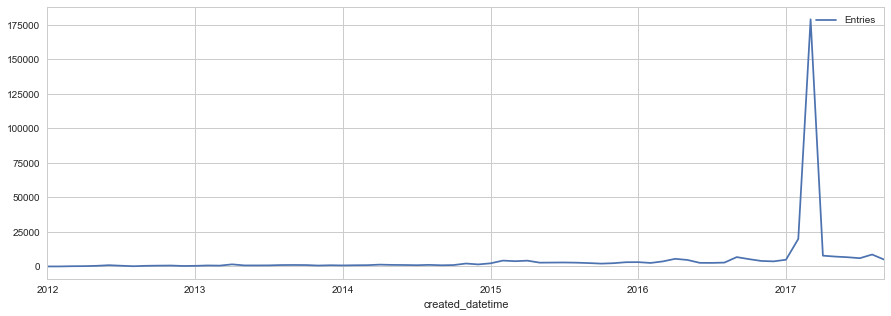

In [16]:
data_hist = data_validdates.groupby(pd.TimeGrouper(key='created_datetime', freq='M'))['created_datetime'].count()
data_hist = pd.DataFrame(data_hist)
data_hist.columns = ["Entries"]
data_hist.plot(figsize=(15,5))

In [17]:
data_hist[data_hist == data_hist.max()].dropna()

,Entries
created_datetime,
2017-03-31,179055.0


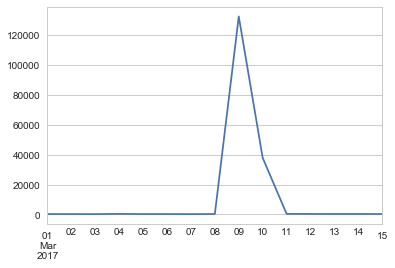

In [18]:
data_hist_zoom = data_validdates['created_datetime'].groupby(data_validdates['created_datetime'].dt.date).count()
data_hist_zoom = data_hist_zoom[pd.date_range("2017-03-01", "2017-03-15")]
data_hist_zoom.plot()

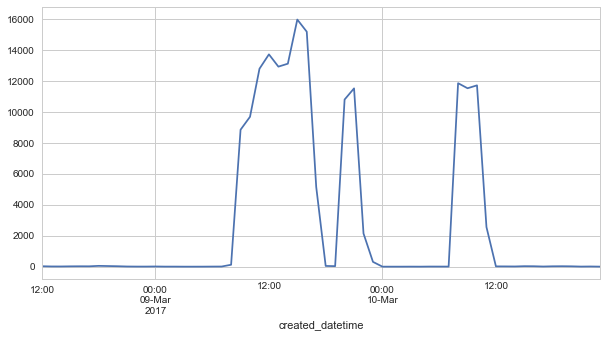

In [19]:
mask = ((data_validdates['created_datetime'] >= "2017-03-08 12:00:00") & (data_validdates['created_datetime'] <= "2017-03-11"))
data_peak = data_validdates[mask]
data_peak = data_peak.groupby(pd.TimeGrouper(key='created_datetime', freq='h'))['created_datetime'].count()
data_peak.columns = ['Entries']
data_peak.plot(figsize=(10,5))

# Food Categories
Is there any relation between category tags and label tags? Can you combine the following two results and come up with some tree based visualization?

In [20]:
categories = data_validcols[['categories_tags']].dropna()
categories = tidy_split(categories, column='categories_tags', sep=',')
categories = pd.DataFrame(categories.groupby(['categories_tags']).size().sort_values(ascending=False))
categories.columns = ['Count']
categories

,Count
categories_tags,
en:plant-based-foods-and-beverages,31311
en:plant-based-foods,26486
en:beverages,17096
en:sugary-snacks,13743
en:dairies,11095
en:cereals-and-potatoes,9278
en:fruits-and-vegetables-based-foods,9116
en:meals,8562
en:non-sugared-beverages,7745


# Food Labels

In [21]:
labels = data_validcols[['labels_tags']].dropna()
labels = tidy_split(labels, column='labels_tags', sep=',')
labels = pd.DataFrame(labels.groupby(['labels_tags']).size().sort_values(ascending=False))
labels.columns = ['Count']
labels

,Count
labels_tags,
en:organic,20097
en:eu-organic,14065
en:green-dot,13177
fr:ab-agriculture-biologique,10128
en:vegetarian,5793
en:vegan,4533
en:no-preservatives,4073
en:gluten-free,3786
fr:eco-emballages,3363


# Comparison between vegan and non vegan foods

In [22]:
data_vege = []
data_nonv = []
for col in nutr_cols:
    data_nutr = data_cats[['categories_tags', 'labels_tags'] + [col]].dropna()
    mask = data_nutr.categories_tags.str.contains("vegan|vegetarian") | data_nutr.labels_tags.str.contains("vegan|vegetarian")
    data_vege.append(data_nutr[mask][col])
    data_nonv.append(data_nutr[~mask][col])
    print(col + ": (" + str(data_vege[-1].shape[0]) + ", " + str(data_nonv[-1].shape[0]) + ")")

energy_100g: (4637, 37751)
fat_100g: (4590, 36709)
carbohydrates_100g: (4604, 36422)
sugars_100g: (4161, 36139)
fiber_100g: (3064, 22692)
proteins_100g: (4592, 37476)
saturated-fat_100g: (4141, 36078)
salt_100g: (4173, 36170)
sodium_100g: (4173, 36169)
nutrition-score-fr_100g: (4006, 35115)
nutrition-score-uk_100g: (4006, 35115)


In [23]:
#Using tensorflow for GPU acceleration because the CPU takes a very long time compute the means this way
nutrs = [[], []]
with tf.Session() as sess:
    for i, cols in enumerate((data_vege, data_nonv)):
        for col in cols:
            nutrs[i].append(sess.run(tf.reduce_mean(tf.constant(col))))
            
nutrs = pd.DataFrame(nutrs)
nutrs.columns = nutr_cols
nutrs = nutrs.rename({0:'Vegan', 1:'Non vegan'})
nutrs = nutrs.T
nutrs

,Vegan,Non vegan
energy_100g,1071.701714,1072.082042
fat_100g,13.575122,13.389372
carbohydrates_100g,26.568032,25.848025
sugars_100g,11.163930,12.005538
fiber_100g,4.106292,2.915634
proteins_100g,6.638625,7.859225
saturated-fat_100g,4.212197,5.400641
salt_100g,1.053886,1.129574
sodium_100g,0.414906,0.444715
nutrition-score-fr_100g,6.030205,7.967194


# Combine following two graphs, you can use zoomed in view ! Donot include table .

In [24]:
energy = nutrs.loc['energy_100g']
nutrs_rest = nutrs.drop(['energy_100g'])

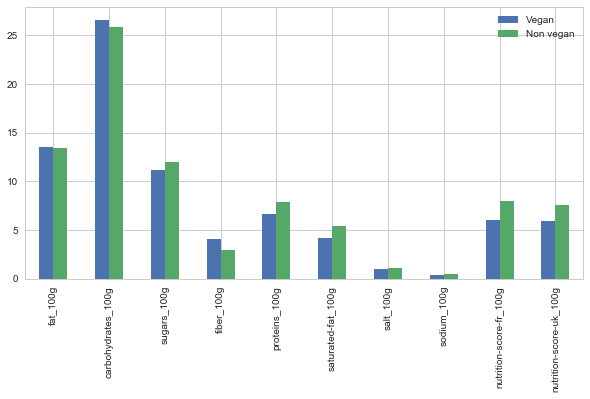

In [25]:
nutrs_rest.plot(kind='bar', figsize=(10,5))

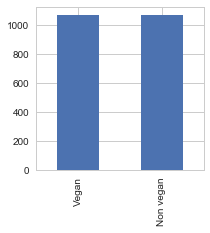

In [26]:
energy.plot(kind='bar', figsize=(3,3))

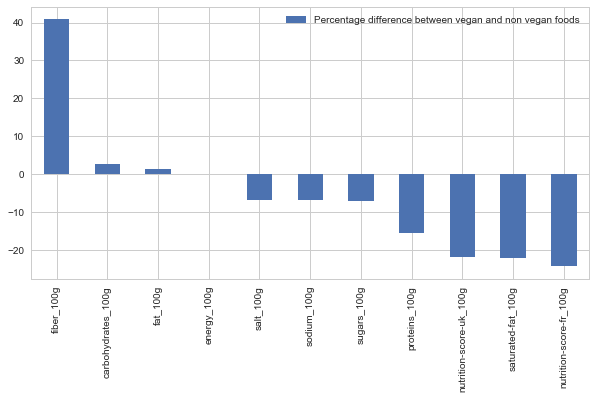

In [27]:
nutrs_ratio = nutrs.apply(lambda x: x['Vegan']/x['Non vegan'], axis=1)
nutrs_ratio = pd.DataFrame(nutrs_ratio).sort_values(ascending=False, by=0)
nutrs_ratio = (nutrs_ratio-1)*100
nutrs_ratio.columns = ['Percentage difference between vegan and non vegan foods']
nutrs_ratio.plot(kind='bar', figsize=(10, 5))

# Comparison between halal and _non-halal_ foods

In [28]:
data_halal = []
data_nothalal = []
for col in nutr_cols:
    data_nutr = data_cats[['categories_tags', 'labels_tags'] + [col]].dropna()
    mask = data_nutr.categories_tags.str.contains("halal") | data_nutr.labels_tags.str.contains("halal")
    data_halal.append(data_nutr[mask][col])
    data_nothalal.append(data_nutr[~mask][col])
    print(col + ": (" + str(data_halal[-1].shape[0]) + ", " + str(data_nothalal[-1].shape[0]) + ")")

energy_100g: (530, 41858)
fat_100g: (529, 40770)
carbohydrates_100g: (523, 40503)
sugars_100g: (506, 39794)
fiber_100g: (229, 25527)
proteins_100g: (529, 41539)
saturated-fat_100g: (500, 39719)
salt_100g: (514, 39829)
sodium_100g: (514, 39828)
nutrition-score-fr_100g: (478, 38643)
nutrition-score-uk_100g: (478, 38643)


In [29]:
#Using tensorflow for GPU acceleration because the CPU takes a very long time compute the means this way
nutrs = [[], []]
with tf.Session() as sess:
    for i, cols in enumerate((data_halal, data_nothalal)):
        for col in cols:
            nutrs[i].append(sess.run(tf.reduce_mean(tf.constant(col))))
            
nutrs = pd.DataFrame(nutrs)
nutrs.columns = nutr_cols
nutrs = nutrs.rename({0:'Halal', 1:'Non halal'})
nutrs = nutrs.T
nutrs

,Halal,Non halal
energy_100g,1030.848962,1072.561997
fat_100g,13.107389,13.413943
carbohydrates_100g,21.447725,25.986688
sugars_100g,8.032866,11.968051
fiber_100g,2.620655,3.061195
proteins_100g,10.316278,7.693001
saturated-fat_100g,4.645558,5.286242
salt_100g,3.628414,1.089396
sodium_100g,1.428573,0.428894
nutrition-score-fr_100g,10.974895,7.729188


# Combine following two graphs, donot include table !

In [30]:
energy = nutrs.loc['energy_100g']
nutrs_rest = nutrs.drop(['energy_100g'])

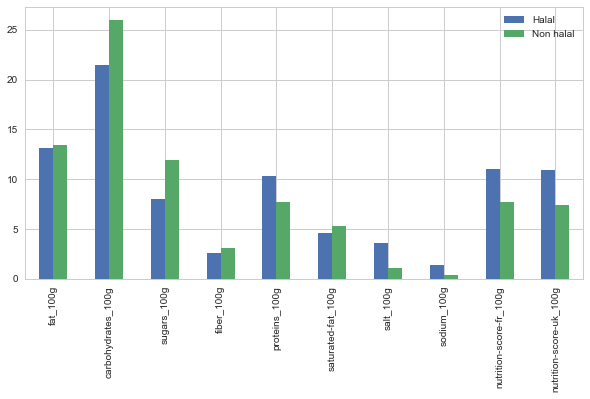

In [31]:
nutrs_rest.plot(kind='bar', figsize=(10,5))

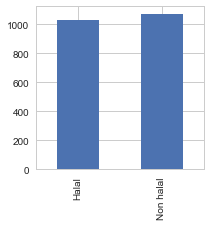

In [32]:
energy.plot(kind='bar', figsize=(3,3))

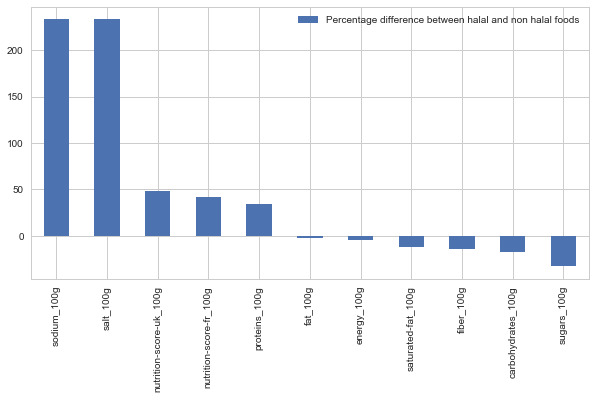

In [33]:
nutrs_ratio = nutrs.apply(lambda x: x['Halal']/x['Non halal'], axis=1)
nutrs_ratio = pd.DataFrame(nutrs_ratio).sort_values(ascending=False, by=0)
nutrs_ratio = (nutrs_ratio-1)*100
nutrs_ratio.columns = ['Percentage difference between halal and non halal foods']
nutrs_ratio.plot(kind='bar', figsize=(10, 5))

# Imports and Exports

This does not make sense because neither origins nor manufacturing_places are correlated with countries


# correlation value range is -1 to +1 ! how you are getting value up to 8000?

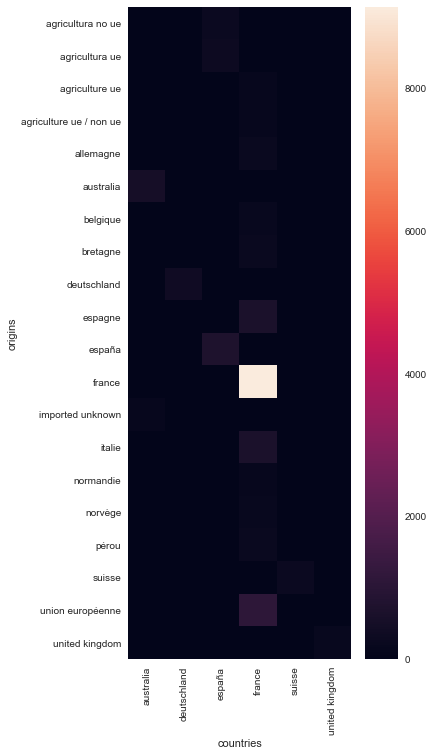

In [34]:
data_io = data_validcols[['origins', 'countries']].dropna()
data_io = tidy_split(data_io, column='origins', sep=',')
data_io = tidy_split(data_io, column='countries', sep=',')
data_io = pd.DataFrame(data_io.groupby([data_io.origins.str.lower(), data_io.countries.str.lower()]).size()).reset_index()
data_io = data_io.nlargest(20, 0)

data_io = data_io.pivot(index='origins', columns='countries', values=0)
data_io = data_io.fillna(0)
plt.subplots(figsize=(5, 12))
sns.heatmap(data_io)
plt.show()

# Sugar contents comparison between countries

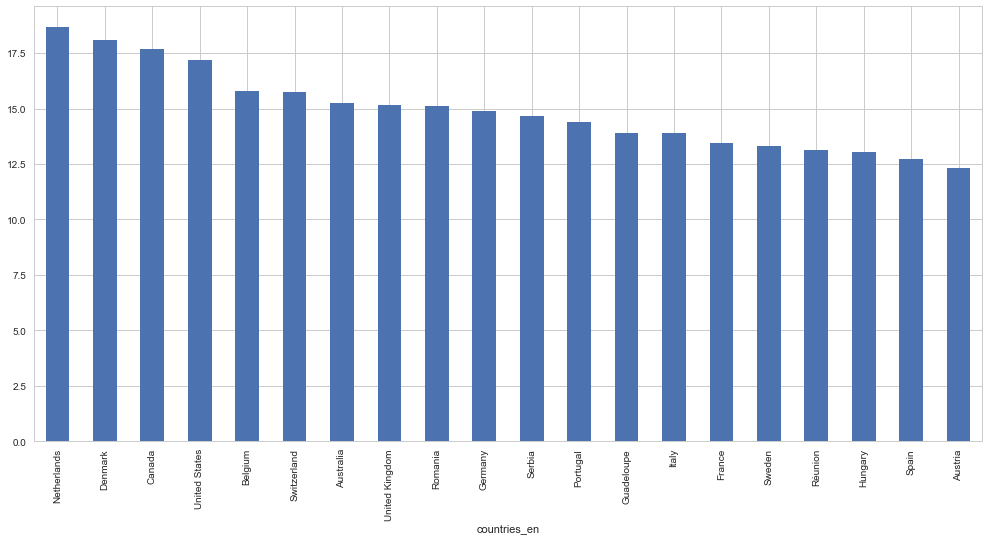

In [35]:
def f(x):
    d = {}
    d['size'] = x['sugars_100g'].count()
    d['mean'] = x['sugars_100g'].mean()
    return pd.Series(d, index=['size', 'mean'])

data_sugar = data_validcols[['countries_en', 'sugars_100g']].dropna()
data_sugar = tidy_split(data_sugar, column='countries_en', sep=',')
data_sugar = data_sugar.groupby(['countries_en']).apply(f)
data_sugar = data_sugar.nlargest(20, ['size']).sort_values(ascending=False, by='mean')
data_sugar['mean'].plot(kind='bar', figsize=(17,8))

# Fat contents comparison between countries

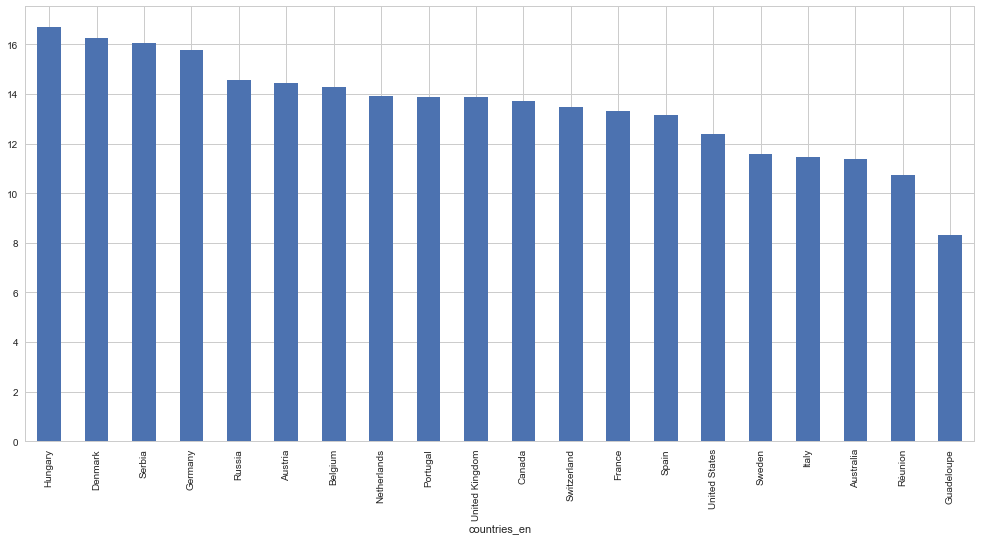

In [36]:
def f(x):
    d = {}
    d['size'] = x['fat_100g'].count()
    d['mean'] = x['fat_100g'].mean()
    return pd.Series(d, index=['size', 'mean'])

data_fat = data_validcols[['countries_en', 'fat_100g']].dropna()
data_fat = tidy_split(data_fat, column='countries_en', sep=',')
data_fat = data_fat.groupby(['countries_en']).apply(f)
data_fat = data_fat.nlargest(20, ['size']).sort_values(ascending=False, by='mean')
data_fat['mean'].plot(kind='bar', figsize=(17,8))

# Alcohol contents comparison between countries

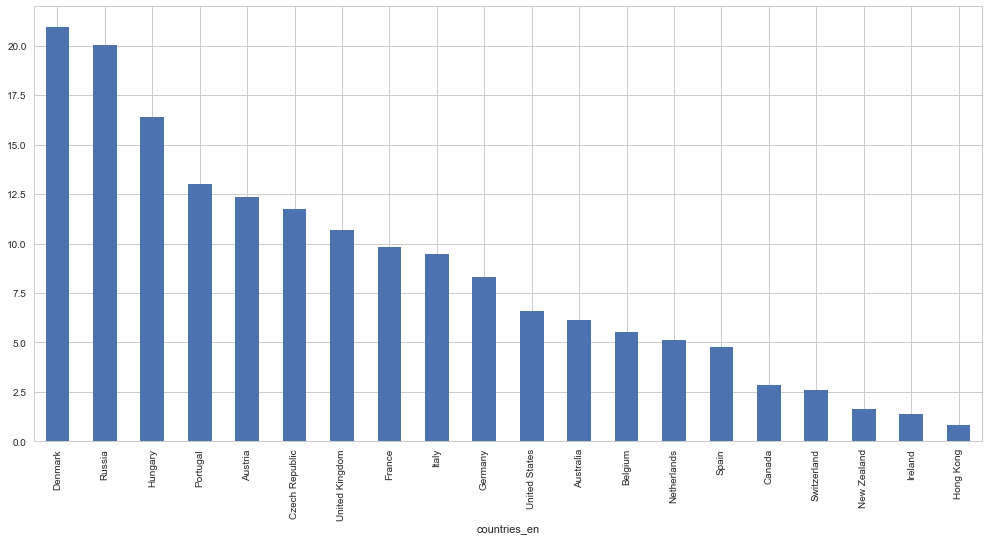

In [37]:
def f(x):
    d = {}
    d['size'] = x['alcohol_100g'].count()
    d['mean'] = x['alcohol_100g'].mean()
    return pd.Series(d, index=['size', 'mean'])

data_alc = data_validcols[['countries_en', 'alcohol_100g']].dropna()
data_alc = tidy_split(data_alc, column='countries_en', sep=',')
data_alc = data_alc.groupby(['countries_en']).apply(f)
data_alc = data_alc.nlargest(20, ['size']).sort_values(ascending=False, by='mean')
data_alc['mean'].plot(kind='bar', figsize=(17,8))

# Comparison of nutrient contents between categories

In [38]:
def f(x):
    d = {}
    d['size'] = x['main_category'].count()
    for col in nutr_cols_important:
        d[col] = x[col].mean()
    return pd.Series(d, index=['size']+nutr_cols_important)

data_test = data_validcols[['main_category'] + nutr_cols_important].dropna()
data_test = data_test.groupby(['main_category']).apply(f)
data_test = data_test.sort_values(by='size', ascending=False)
data_test = data_test[:15]
data_test = data_test[nutr_cols_important]
data_test

,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g
main_category,,,,,,
en:plant-based-foods-and-beverages,1152.221752,9.545597,38.096712,9.846695,4.511183,7.392583
en:sugary-snacks,1896.588798,21.772184,57.478387,33.171923,3.941013,6.493316
en:beverages,283.904241,1.028593,13.113273,11.374391,1.061873,1.175872
en:dairies,651.460717,9.894467,8.797450,7.347900,0.361453,7.844678
en:groceries,807.809097,13.432097,14.064013,8.460543,1.689345,3.018859
en:meals,626.645466,6.641751,14.766620,2.330414,1.968695,6.814529
en:fresh-foods,811.157303,12.534038,10.281338,5.079233,0.827502,9.798055
en:salty-snacks,2034.547562,25.491016,54.643320,4.085922,4.164804,8.015251
en:meats,900.678974,14.059933,2.687796,0.966872,0.583455,19.446728


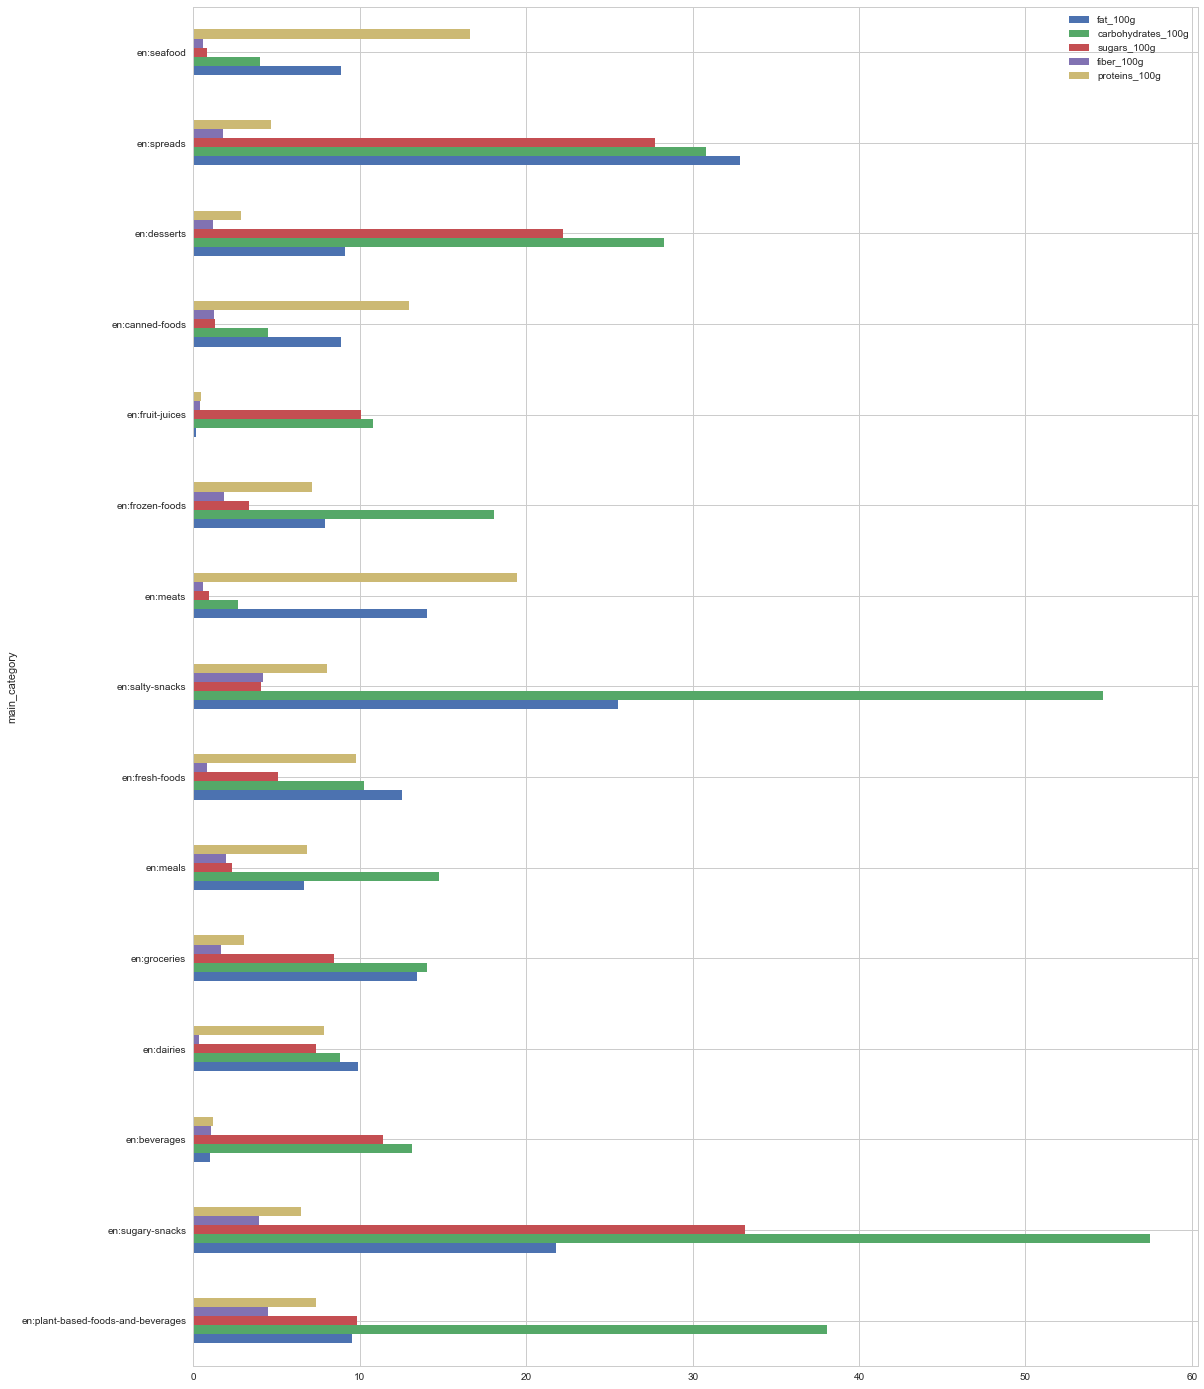

In [39]:
energy = data_test[['energy_100g']]
nutrs_rest = data_test.drop(['energy_100g'], axis=1)

nutrs_rest.plot(kind='barh', figsize=(18,25))

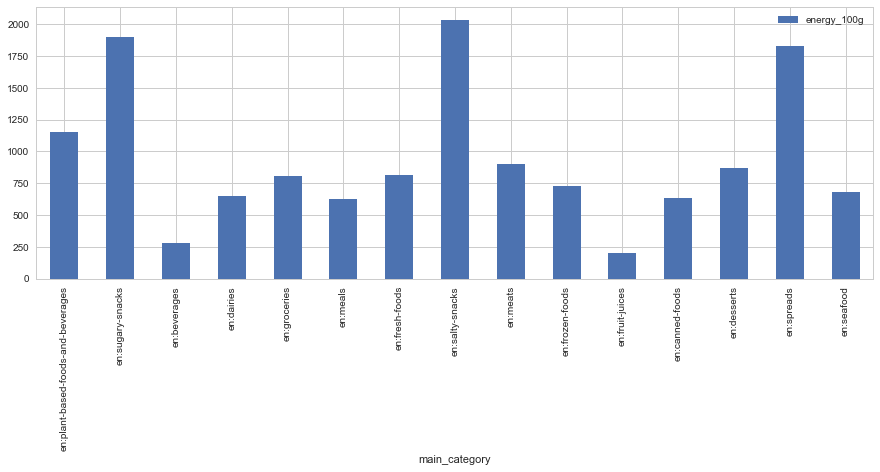

In [40]:
energy.plot(kind='bar', figsize=(15,5))

# Correlation between product name and ingredients

Vectorize string and apply cosine similarity on the string vectors

# please explain this, I am not getting what you are trying to explore here !

In [41]:
data_names = data_validcols[['product_name', 'ingredients_text']].dropna()

clf = TfidfVectorizer()
clf.fit(data_names['product_name'] + " " + data_names['ingredients_text'])
A = clf.transform(data_names['product_name'])
B = clf.transform(data_names['ingredients_text'])

data_names['sim'] = 1-paired_cosine_distances(A, B)

In [42]:
data_names = data_names.sort_values(by='sim', ascending=False)
data_names.head()

,product_name,ingredients_text,sim
174240,Pure Spring Water,Pure spring water,1.0
344988,Orégãos,orégãos,1.0
296417,Granulated Sugar,Granulated sugar,1.0
53039,Extra Light Tasting Olive Oil,Extra light tasting olive oil,1.0
53036,Olive Oil,Olive oil.,1.0


In [43]:
data_names['sim'].mean()

0.17144007234595862

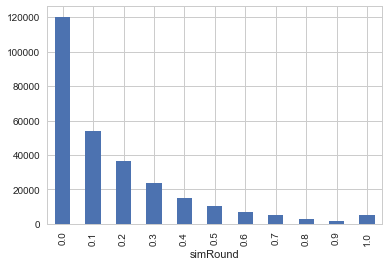

In [44]:
data_names['simRound'] = data_names['sim'].round(1)
roundedSim = data_names.groupby(['simRound']).size()
roundedSim.plot(kind='bar')

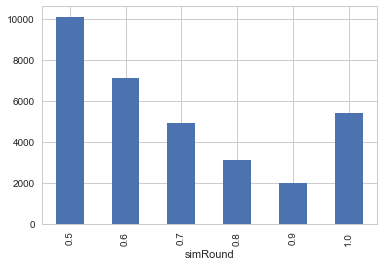

In [45]:
roundedSim = roundedSim.drop([0.0, 0.1, 0.2, 0.3, 0.4])
roundedSim.plot(kind='bar')